# Generate and Extract Dataset

## Load Datasets

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATASET = []

- **TRUE** : `1`
- **FAKE** : `0`

### [Fake and real news dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv )

In [3]:
# Download the dataset
%pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip "fake-and-real-news-dataset.zip"
!rm "fake-and-real-news-dataset.zip"

Note: you may need to restart the kernel to use updated packages.
mkdir: cannot create directory ‘/home/felipe/.kaggle’: File exists
chmod: cannot access '/root/.kaggle/kaggle.json': Permission denied
100%|██████████████████████████████████████| 41.0M/41.0M [00:02<00:00, 21.6MB/s]
100%|██████████████████████████████████████| 41.0M/41.0M [00:02<00:00, 14.6MB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [4]:
# Read the dataset of the True
df = pd.read_csv("True.csv")
# Standardize the dataset
df["features"] = df["title"] + " " + df["text"]
df["label"] = 1
df.drop(["title", "text", "subject", "date"], axis=1, inplace=True)
# Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [8]:
# Read the dataset of the True
df = pd.read_csv("Fake.csv")
# Standardize the dataset
df["features"] = df["title"] + " " + df["text"]
df["label"] = 0
df.drop(["title", "text", "subject", "date"], axis=1, inplace=True)
# Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [10]:
!rm *.csv

### [Fake News Dataset](https://data.mendeley.com/datasets/945z9xkc8d/1)

In [7]:
# !curl -L "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/945z9xkc8d-1.zip" -o data.zip
# !unzip "data.zip" && unzip "Fake News Dataset.zip"
# !rm -r *.zip

# main_directory = os.path.join(os.getcwd(),"Fake News Dataset")
# subdirectories = [x[0] for x in os.walk(main_directory)][1:]
# print(main_directory)
# dataframes = []
# test = []
# # Itera a través de los subdirectorios y archivos train.csv
# for subdirectory in subdirectories:
#     file_path = os.path.join(subdirectory, "train.csv")
#     test_path = os.path.join(subdirectory, "test.csv")

#     # Verifica si el archivo train.csv existe en el subdirectorio
#     if os.path.exists(file_path):
#         data = pd.read_csv(file_path)
#         dataframes.append(data)

#     if os.path.exists(test_path):
#         data = pd.read_csv(test_path)
#         test.append(data)

# # Combina los DataFrames en uno solo
# train_data = pd.concat(dataframes, ignore_index=True)
# test_data = pd.concat(test,ignore_index=True)
# !rm -r "Fake News Dataset"
# # Guarda el DataFrame combinado en un archivo train_combined.csv
# train_data.to_csv("train.csv", index=False)
# test_data.to_csv("test.csv", index=False)

### [GonzaloA/fake_news](https://huggingface.co/datasets/GonzaloA/fake_news)

In [11]:
# Download the dataset
!curl -L "https://huggingface.co/datasets/GonzaloA/fake_news/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet" -o 0.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   998  100   998    0     0   2431      0 --:--:-- --:--:-- --:--:--  2434
100 36.9M  100 36.9M    0     0  13.4M      0  0:00:02  0:00:02 --:--:-- 17.3M


In [12]:
# Read the Dataset
df = pd.read_parquet("0.parquet")
# Standardize the dataset
df["features"] = df["title"] + " " + df["text"]
df.drop(["title", "text", "Unnamed: 0"], axis=1, inplace=True)
df.insert(0, "features", df.pop("features"))
# Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
0,‘Maury’ Show Official Facebook Posts F*CKED U...,0
1,Trump’s Favorite News Channel Tries To Soothe...,0
2,"Russia warns Iraq, Kurds not to destabilize Mi...",1
3,WATCH STEVE SCALISE Throw A Strike At The Nati...,0
4,Trump Will HATE What Stephen Colbert Just Did...,0


In [17]:
!rm *.parquet

### [ErfanMoosaviMonazzah/fake-news-detection-dataset-English](https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English)

In [18]:
# Download the dataset
!curl -L "https://huggingface.co/api/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English/parquet/default/train/0.parquet" -o 0.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100   170  100   170    0     0    992      0 --:--:-- --:--:-- --:--:--   994
100  1127  100  1127    0     0   3362      0 --:--:-- --:--:-- --:--:--  3362
100 46.0M  100 46.0M    0     0  16.5M      0  0:00:02  0:00:02 --:--:-- 24.6M


In [19]:
# Read the Dataset
df = pd.read_parquet("0.parquet")
# Standardize the dataset
df["features"] = df["title"] + " " + df["text"]
df.drop(["title", "text", "Unnamed: 0", "date", "subject"], axis=1, inplace=True)
df.insert(0, "features", df.pop("features"))
# Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
0,Ex-CIA head says Trump remarks on Russia inter...,1
1,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,0
2,Federal Reserve governor Powell's policy views...,1
3,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,0
4,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,0


In [24]:
!rm *.parquet

### [mohammadjavadpirhadi/fake-news-detection-dataset-english](https://huggingface.co/datasets/mohammadjavadpirhadi/fake-news-detection-dataset-english)

In [25]:
!curl -L "https://huggingface.co/api/datasets/mohammadjavadpirhadi/fake-news-detection-dataset-english/parquet/default/train/0.parquet" -o 0.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100   170  100   170    0     0    338      0 --:--:-- --:--:-- --:--:--   339
100  1121  100  1121    0     0   1751      0 --:--:-- --:--:-- --:--:--  1751
100 54.3M  100 54.3M    0     0  14.1M      0  0:00:03  0:00:03 --:--:-- 17.2M


In [26]:
# Read the Dataset
df = pd.read_parquet("0.parquet")
# Standardize the dataset
df["features"] = df["title"] + " " + df["text"]
df.drop(["title", "text", "date", "subject"], axis=1, inplace=True)
df.insert(0, "features", df.pop("features"))
df["label"] = df["label"].apply(lambda x: 1 if x == 0 else 0)

# Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
0,"Saudi Arabia says foils Islamic State bomb, fo...",1
1,GOP Just Demanded Hillary Clinton Give Them A...,0
2,AUDIT REVEALS: 150 AFGHAN TROOPS Have Gone AWO...,0
3,Watch Elizabeth Warren DESTROY Donald Trump i...,0
4,Mohammed Dahlan speaks about Palestinian unity...,1


In [31]:
!rm *.parquet

### [pushpdeep/fake_news_combined](https://huggingface.co/datasets/pushpdeep/fake_news_combined)

In [32]:
!curl -L "https://huggingface.co/api/datasets/pushpdeep/fake_news_combined/parquet/default/train/0.parquet" -o 0.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   142  100   142    0     0    432      0 --:--:-- --:--:-- --:--:--   432
100  1119  100  1119    0     0   2434      0 --:--:-- --:--:-- --:--:--  2434
100 67.9M  100 67.9M    0     0  17.5M      0  0:00:03  0:00:03 --:--:-- 24.2M


In [33]:
# Read the Dataset
df = pd.read_parquet("0.parquet")
# Standardize the dataset
df["features"] = df["text"]
df.drop(["Unnamed: 0", "text"], axis=1, inplace=True)
df.insert(0, "features", df.pop("features"))

# # Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
0,FBI and DOJ Refusing To Comply With Subpoena O...,0
1,MarkLevin is Freaking Awesome: Obama negotiate...,0
2,Judges rule Trump University can appeal to New...,1
3,EU's Barnier worried by UK's post-Brexit plan ...,1
4,Russia says U.S. decision on Jerusalem may wor...,1


In [38]:
!rm *.parquet

### [argilla/news-fakenews](https://huggingface.co/datasets/argilla/news-fakenews)

In [39]:
!curl -L "https://huggingface.co/api/datasets/argilla/news-fakenews/parquet/default/train/0.parquet" -o 0.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   135  100   135    0     0    373      0 --:--:-- --:--:-- --:--:--   372
100  1123  100  1123    0     0   2279      0 --:--:-- --:--:-- --:--:--  2279
100  131M  100  131M    0     0  19.7M      0  0:00:06  0:00:06 --:--:-- 25.5M


In [40]:
# Read the Dataset
df = pd.read_parquet("0.parquet")
# Standardize the dataset
df = df[["text","prediction"]]
df = df[df["text"] != ' ']
df["prediction"] = df["prediction"].apply(lambda x: 1 if x[0]["label"] == 'real' else 0)
df.columns = ["features", "label"]
# Add the dataset to the list
DATASET.append(df)
# Show
df.head(5)

,features,label
1,"TOWNSVILLE, Australia (Reuters) - It was early...",1
2,CARACAS (Reuters) - Venezuela s opposition coa...,1
3,WASHINGTON (Reuters) - U.S. President Donald T...,1
4,ISTANBUL (Reuters) - Turkey s President Tayyip...,1
5,WASHINGTON (Reuters) - The top Democrat in the...,1


In [45]:
!rm *.parquet

### Join all the data

In [51]:
df = pd.concat(DATASET, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the dataset
df.to_csv("train.csv", index=False)
del DATASET

## Inspeccionar datos

In [52]:
df.head(5)

,features,label
0,Coke Zero: What Went Wrong With The Marco Rubi...,0
1,The depths of Republican cruelty is on full di...,0
2,JAL to screen majority-muslim country passenge...,1
3,"Yes, this actually happened.During a panel dis...",0
4,BREAKING BAD: John McCain’s Campaign Rocked by...,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224338 entries, 0 to 224337
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   features  224338 non-null  object
 1   label     224338 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


# Visualizacion del Dataset

## Dataset Balanceado

Text(-21.180555555555557, 0.5, 'Conteo')

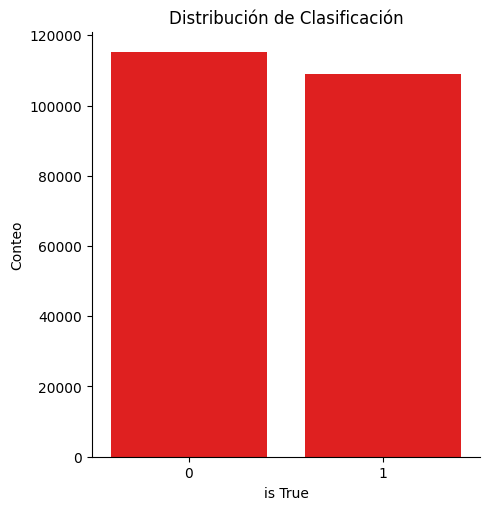

In [54]:
## Librerias para graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizamos si la data esta balanceada
sns.catplot(x="label", kind="count", color="r", data=df)
plt.title("Distribución de Clasificación")
plt.xlabel("is True")
plt.ylabel("Conteo")

## Word Cloud de los titulares de las *Fake News*

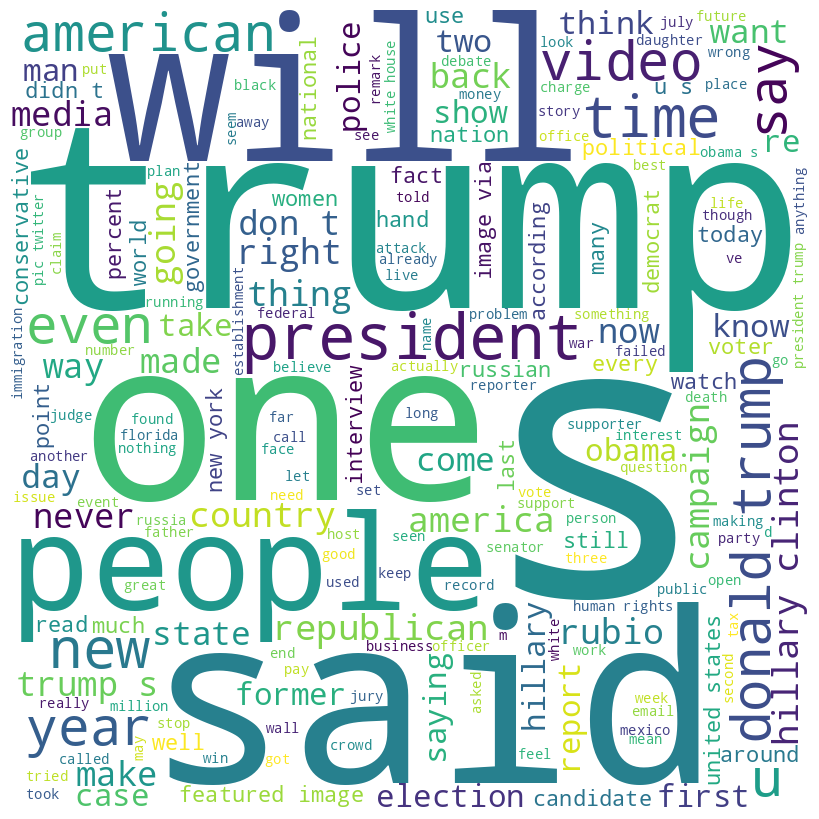

In [62]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
comment_words = ""
stopwords = set(STOPWORDS)
# Recorrer el dataframe
for val in df[df["label"] == 0]["features"][:100]:
    # Castear cada palabra a string
    val = str(val)
    # Separamos por palabra
    tokens = val.split()
    # Pasamos a minusculas
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens) + " "
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words)
# Generamos el plot
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

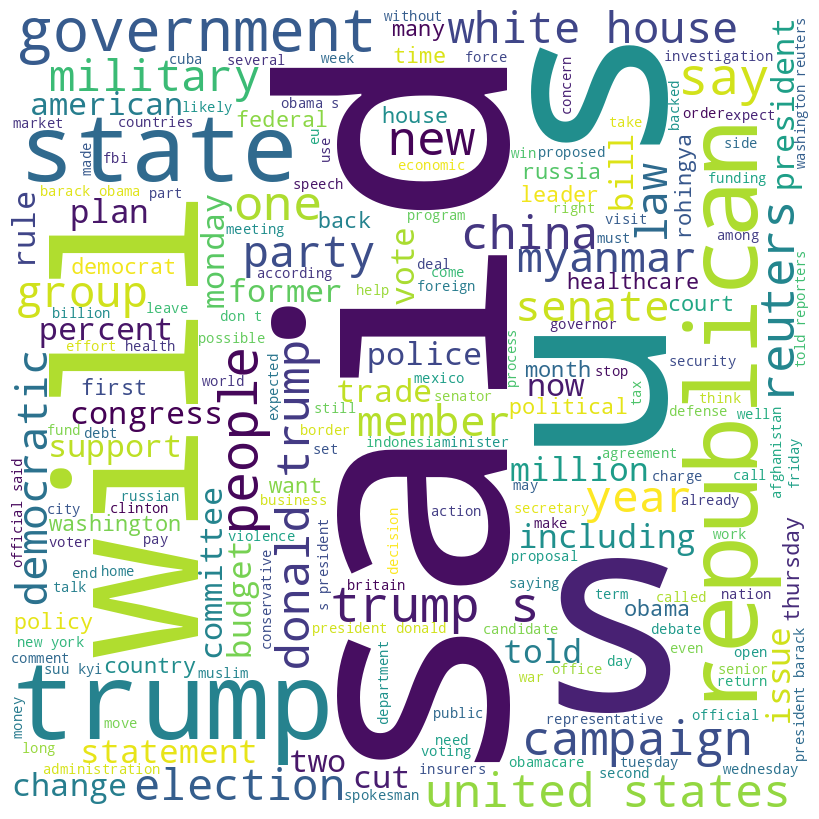

In [63]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
comment_words = ""
stopwords = set(STOPWORDS)
# Recorrer el dataframe
for val in df[df["label"] == 1]["features"][:100]:
    # Castear cada palabra a string
    val = str(val)
    # Separamos por palabra
    tokens = val.split()
    # Pasamos a minusculas
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens) + " "
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words)
# Generamos el plot
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Pre-Procesado de los datos para NLP

In [12]:
df = pd.read_csv("train.csv")

# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
import re
'''
* processing_text
* @param texto str
* @return processed_feature str
'''
def processing_text(texto):

    # 1. Limpiar textos
    processed_feature = re.sub(r'[^a-zA-Z0-9 ]', '', str(texto)) # Remover con un expresión regular carateres especiales (no palabras).
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature) # Remover ocurrencias de caracteres individuales
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) # Remover ocurrencias de caracteres individuales
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature) #  Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(' +', ' ', processed_feature) # Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = processed_feature.lower() # Pasar todo el texto a minúsculas
    
    # 2. Stop words & lemmatization
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    processed_feature = processed_feature.split()
    processed_feature = ' '.join([lemmatizer.lemmatize(word) for word in processed_feature if word not in stop_words])

    return processed_feature

In [14]:
df["features"] = df["features"].apply(processing_text)

# Save the data

In [15]:
df.to_json("features.json",orient='records', lines=True)